<a href="https://colab.research.google.com/github/antonsmedberg/Inl-mning-projekt-del-1/blob/main/ITHSAntonAi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Nödvändiga Bibliotek**

In [28]:
# Installera TensorFlow och OpenCV
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds



# **Ladda och Förbered Oxford Pets Dataset**





In [29]:
# Ladda Oxford Pets Dataset
(train_ds, val_ds), dataset_info = tfds.load(
    'oxford_iiit_pet', split=['train', 'test'],
    with_info=True, as_supervised=True
)

# Funktion för att formatera om bilder och etiketter
def preprocess_data(image, label):
    image = tf.image.resize(image, (416, 416)) / 255.0  # Skala bilderna till 416x416

    # Gör om etiketten till en one-hot-vektor för klassificering och lägg till bounding box-dummy-data
    num_classes = dataset_info.features['label'].num_classes
    label = tf.one_hot(label, depth=num_classes)  # One-hot för klassificering
    label = tf.reshape(label, (-1,))  # Omforma till vektor

    # Lägg till fyra dummy-koordinater för bounding box (ex: [0, 0, 1, 1])
    label = tf.concat([tf.zeros((4,)), label], axis=0)  # Bounding box-data + klasser

    # Omforma för att matcha modellens output (1, 37) där 37 är klasser + bounding box-koordinater
    label = tf.reshape(label, (1, -1))
    return image, label

# Applicera preprocessering och batchning utanför preprocess_data-funktionen
train_ds = train_ds.map(preprocess_data).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data).batch(32).prefetch(tf.data.AUTOTUNE)






# **Cell 3: Skapa ResNet50 + YOLO-liknande Modell**

In [30]:
import os
import json
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm  # För progressbar
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Reshape
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras.backend as K

def create_resnet_yolo_model(input_shape=(416, 416, 3), num_classes=37, num_anchors=1):
    """
    Skapar en kombinerad modell med ResNet50 som feature extractor och en YOLO-liknande Detection Head.
    """
    # Ladda ResNet50 som feature extractor utan den översta delen
    base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)

    # Lägg till GlobalAveragePooling för att minska dimensionen på feature mappen
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # YOLO-liknande lager för att förutsäga bounding boxes och klasser
    output_units = num_classes + 4  # 4 för bounding box-koordinater (x, y, width, height) + klasser
    x = Dense(1024, activation="relu")(x)
    x = Dense(512, activation="relu")(x)
    x = Dense(num_anchors * output_units, activation="linear")(x)
    x = Reshape((num_anchors, output_units))(x)  # Omformar till (ankare, klasser + box)

    # Skapa och returnera modellen
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Skapa modellen
model = create_resnet_yolo_model()
model.summary()

# Anpassad förlustfunktion
def yolo_loss(y_true, y_pred):
    """
    Förlustfunktion för YOLO-modellen, som kombinerar bounding box-regression och klassificering.
    """
    # Dela upp förutsägelserna i koordinater och klassprediktioner
    coord_true = y_true[..., :4]  # bounding box-koordinater
    classes_true = y_true[..., 4:]  # klasser

    coord_pred = y_pred[..., :4]
    classes_pred = y_pred[..., 4:]

    # Bounding box-regression (Mean Squared Error)
    coord_loss = K.sum(K.square(coord_true - coord_pred))

    # Klassificeringsförlust (Categorical Crossentropy) - justerar för att hantera batchstorleken
    class_loss = K.categorical_crossentropy(classes_true, classes_pred, from_logits=True)
    class_loss = K.sum(class_loss)

    # Total förlust
    total_loss = coord_loss + class_loss
    return total_loss

# Kompilera modellen med förlustfunktionen
model.compile(optimizer='adam', loss=yolo_loss)

# Anpassa bilder i datasetet för att matcha input
def resize_images(image, label):
    image = tf.image.resize(image, [416, 416])  # Resizes till (416, 416)
    return image, label

# Använd transformationen på tränings- och valideringsdatasetet så att bilderna är i rätt format
train_ds = train_ds.map(resize_images)
val_ds = val_ds.map(resize_images)






Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 416, 416, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 422, 422, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 208, 208, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 208, 208, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 208, 208, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 210, 210, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 104, 104, 64)   │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 104, 104, 64)   │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 104, 104, 64)   │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 104, 104, 64)   │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 104, 104, 64)   │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 104, 104, 64)   │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 104, 104, 64)   │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 104, 104, 256)  │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 104, 104, 256)  │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,231,721 (100.07 MB)

 Trainable params: 26,178,601 (99.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

# **Cell 5: Träna Modellen**

In [31]:
import os
import json
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm  # För progressbar

# Radera gamla checkpoints och träningsstatus om du vill börja om helt
def reset_checkpoints():
    if os.path.exists('model_checkpoint_latest.weights.h5'):
        os.remove('model_checkpoint_latest.weights.h5')
    if os.path.exists('model_checkpoint_backup.weights.h5'):
        os.remove('model_checkpoint_backup.weights.h5')
    if os.path.exists('training_status.json'):
        os.remove('training_status.json')

# Använd funktionen för att börja från början
reset_checkpoints()

# Ladda sparad träningsstatus eller börja från epok 0
def load_training_status(training_status_file='training_status.json'):
    if os.path.exists(training_status_file):
        with open(training_status_file, 'r') as f:
            status = json.load(f)
        return status.get("current_epoch", 0)
    return 0

# Spara träningsstatus till JSON-fil
def save_training_status(epoch, training_status_file='training_status.json'):
    status = {
        "current_epoch": epoch,
        "last_saved": datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    with open(training_status_file, 'w') as f:
        json.dump(status, f)

# Loggningsfunktion
def log_message(message, log_file='training_log.txt'):
    print(message)
    with open(log_file, 'a') as f:
        f.write(message + '\n')

# Funktion för att ladda senaste giltiga checkpoint
def load_weights_safe(model, checkpoint_paths=['model_checkpoint_latest.weights.h5', 'model_checkpoint_backup.weights.h5']):
    for checkpoint_path in checkpoint_paths:
        if os.path.exists(checkpoint_path):
            try:
                model.load_weights(checkpoint_path)
                log_message(f"Laddade vikter från checkpoint ({checkpoint_path}).")
                return True
            except Exception as e:
                log_message(f"Misslyckades med att ladda checkpoint {checkpoint_path}: {e}")
    log_message("Ingen giltig checkpoint hittades. Startar träningen från början.")
    return False

# Fryser ResNet50-lagren för att endast träna Detection Head
for layer in model.layers[:-3]:
    layer.trainable = False

# Kompilera modellen med vald förlustfunktion
model.compile(
    optimizer='adam',
    loss=yolo_loss,
    metrics=['accuracy']
)

# Skapa en checkpoint-callback som sparar modellen efter varje epok
checkpoint_callback = ModelCheckpoint(
    filepath='model_checkpoint_latest.weights.h5',
    save_weights_only=True,
    save_freq='epoch',
    verbose=0
)

# Träningsfunktion som delar upp träningen i omgångar
def train_in_batches(model, train_ds, val_ds, epochs_per_batch, total_epochs, checkpoint_callback):
    current_epoch = load_training_status()
    if current_epoch > 0:
        log_message(f"Återupptar träningen från epok {current_epoch}.")
    else:
        log_message("Startar träningen från början.")

    total_start_time = datetime.now()

    while current_epoch < total_epochs:
        epochs_to_train = min(epochs_per_batch, total_epochs - current_epoch)
        batch_start_time = datetime.now()
        log_message(f"\n-----\n[{batch_start_time}] Startar omgång {current_epoch // epochs_per_batch + 1} med {epochs_to_train} epoker...")

        pbar = tqdm(total=epochs_to_train, desc=f"Omgång {current_epoch // epochs_per_batch + 1}/{total_epochs // epochs_per_batch}", unit="epok")

        try:
            for epoch in range(epochs_to_train):
                history = model.fit(
                    train_ds,
                    epochs=current_epoch + 1,
                    validation_data=val_ds,
                    callbacks=[checkpoint_callback],
                    initial_epoch=current_epoch,
                    verbose=0
                )

                current_epoch += 1
                pbar.update(1)

                # Tidsberäkning
                elapsed_time = datetime.now() - batch_start_time
                avg_epoch_time = elapsed_time / (epoch + 1)
                remaining_time = avg_epoch_time * (epochs_to_train - (epoch + 1))

                # Logga träningsförlust och valideringsförlust
                train_loss = history.history['loss'][-1]
                val_loss = history.history['val_loss'][-1]
                pbar.set_postfix({
                    "Träningsförlust": f"{train_loss:.4f}",
                    "Valideringsförlust": f"{val_loss:.4f}",
                    "Kvarvarande tid": str(timedelta(seconds=int(remaining_time.total_seconds())))
                })

                save_training_status(current_epoch)  # Spara träningsstatus

        except Exception as e:
            log_message(f"Fel under träningen på epok {current_epoch}: {e}")
            break

        pbar.close()
        batch_end_time = datetime.now()
        batch_duration = batch_end_time - batch_start_time
        log_message(f"[{batch_end_time}] Omgång {current_epoch // epochs_per_batch} avslutad. Tidsåtgång: {batch_duration}.")

    # Total träningslogg
    total_end_time = datetime.now()
    total_duration = total_end_time - total_start_time
    log_message(f"\n-----\nTräningen slutförd. Total tidsåtgång: {total_duration}.\n")

# Ladda vikter från senaste checkpoint om den finns
load_weights_safe(model)

# Kör träningen i omgångar
train_in_batches(model, train_ds, val_ds, epochs_per_batch=5, total_epochs=30, checkpoint_callback=checkpoint_callback)







Ingen giltig checkpoint hittades. Startar träningen från början.
Startar träningen från början.

-----
[2024-11-04 12:55:50.500897] Startar omgång 1 med 5 epoker...


Omgång 1/6: 100%|██████████| 5/5 [07:40<00:00, 92.18s/epok, Träningsförlust=113.3991, Valideringsförlust=112.6656, Kvarvarande tid=0:00:00]


[2024-11-04 13:03:31.384397] Omgång 1 avslutad. Tidsåtgång: 0:07:40.883500.

-----
[2024-11-04 13:03:31.384539] Startar omgång 2 med 5 epoker...


Omgång 2/6: 100%|██████████| 5/5 [06:17<00:00, 75.53s/epok, Träningsförlust=111.1589, Valideringsförlust=112.4499, Kvarvarande tid=0:00:00]


[2024-11-04 13:09:49.054903] Omgång 2 avslutad. Tidsåtgång: 0:06:17.670364.

-----
[2024-11-04 13:09:49.056991] Startar omgång 3 med 5 epoker...


Omgång 3/6: 100%|██████████| 5/5 [06:26<00:00, 77.39s/epok, Träningsförlust=109.8375, Valideringsförlust=112.4375, Kvarvarande tid=0:00:00]


[2024-11-04 13:16:16.000168] Omgång 3 avslutad. Tidsåtgång: 0:06:26.943177.

-----
[2024-11-04 13:16:16.000312] Startar omgång 4 med 5 epoker...


Omgång 4/6: 100%|██████████| 5/5 [06:17<00:00, 75.56s/epok, Träningsförlust=108.7731, Valideringsförlust=111.2480, Kvarvarande tid=0:00:00]


[2024-11-04 13:22:33.813174] Omgång 4 avslutad. Tidsåtgång: 0:06:17.812862.

-----
[2024-11-04 13:22:33.813304] Startar omgång 5 med 5 epoker...


Omgång 5/6: 100%|██████████| 5/5 [05:53<00:00, 70.63s/epok, Träningsförlust=107.5467, Valideringsförlust=110.2174, Kvarvarande tid=0:00:00]


[2024-11-04 13:28:26.988538] Omgång 5 avslutad. Tidsåtgång: 0:05:53.175234.

-----
[2024-11-04 13:28:26.988919] Startar omgång 6 med 5 epoker...


Omgång 6/6: 100%|██████████| 5/5 [06:33<00:00, 78.67s/epok, Träningsförlust=106.0898, Valideringsförlust=109.5951, Kvarvarande tid=0:00:00]

[2024-11-04 13:35:00.363203] Omgång 6 avslutad. Tidsåtgång: 0:06:33.374284.

-----
Träningen slutförd. Total tidsåtgång: 0:39:09.862441.



# **Cell 6: Testa och Visa Förutsägelser**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


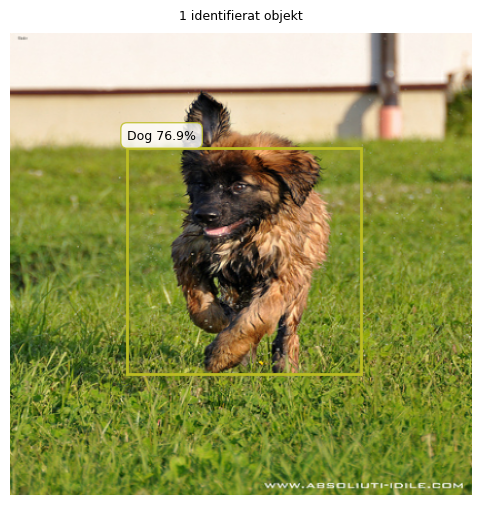

In [54]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
import logging
from enum import Enum

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class DetectionStatus(Enum):
    """Status för olika typer av detektioner"""
    FULL = "full"              # Både objekt och klass identifierade
    UNKNOWN_CLASS = "unknown"   # Objekt hittat men okänd klass
    NAME_ONLY = "name_only"    # Känner igen typ men ingen bounding box
    FAILED = "failed"          # Ingen detektion

@dataclass
class DisplayConfig:
    """Konfiguration för visualisering"""
    figure_size: Tuple[int, int] = (6, 6)
    box_line_width: int = 2
    text_size: int = 9
    unknown_color: Tuple[float, float, float] = (0.7, 0.7, 0.7)  # Grå för okända objekt

@dataclass
class Detection:
    """Information om en detektion"""
    box: Optional[np.ndarray]
    confidence: float
    class_id: Optional[int]
    class_name: Optional[str]
    status: DetectionStatus

class ObjectDetector:
    def __init__(
        self,
        confidence_threshold: float = 0.3,
        custom_classes: Dict[int, str] = None,
        display_config: DisplayConfig = None
    ):
        self.confidence_threshold = confidence_threshold
        self.display_config = display_config or DisplayConfig()
        self.class_names = custom_classes or {
            0: 'Person', 1: 'Bicycle', 2: 'Car', 3: 'Motorcycle',
            4: 'Airplane', 5: 'Bus', 6: 'Train', 7: 'Truck',
            8: 'Boat', 9: 'Traffic Light', 10: 'Fire Hydrant',
            11: 'Stop Sign', 12: 'Parking Meter', 13: 'Bench',
            14: 'Bird', 15: 'Cat', 16: 'Dog', 17: 'Horse',
            18: 'Sheep', 19: 'Cow'
        }
        self._setup_visualization()

    def _setup_visualization(self) -> None:
        """Konfigurerar visualiseringsparametrar"""
        np.random.seed(42)
        base_colors = plt.cm.tab20(np.linspace(0, 1, len(self.class_names)))
        self.colors = {
            class_id: color[:3] for class_id, color in enumerate(base_colors)
        }

    @staticmethod
    def sigmoid(x: np.ndarray) -> np.ndarray:
        """Applicerar sigmoid med numerisk stabilitet"""
        return 1 / (1 + np.exp(-np.clip(x, -50, 50)))

    def determine_detection_status(
        self,
        box_confidence: float,
        class_confidence: float
    ) -> DetectionStatus:
        """Avgör detektionsstatus baserat på confidence-värden"""
        if box_confidence > self.confidence_threshold and class_confidence > self.confidence_threshold:
            return DetectionStatus.FULL
        elif box_confidence > self.confidence_threshold:
            return DetectionStatus.UNKNOWN_CLASS
        elif class_confidence > self.confidence_threshold:
            return DetectionStatus.NAME_ONLY
        return DetectionStatus.FAILED

    def process_predictions(self, predictions: np.ndarray) -> List[Detection]:
        """Processar prediktioner med förbättrad felhantering"""
        detections = []
        try:
            for pred in predictions[0]:
                # Beräkna box confidence
                box = pred[:4]
                box_normalized = self.sigmoid(box)
                box_confidence = np.mean(self.sigmoid(np.abs(box)))

                # Beräkna class confidence
                scores = pred[4:]
                class_id = np.argmax(scores)
                class_confidence = self.sigmoid(scores[class_id])

                # Bestäm status för detektionen
                status = self.determine_detection_status(box_confidence, class_confidence)

                # Skapa detection baserat på status
                if status == DetectionStatus.FULL:
                    detection = Detection(
                        box=box_normalized,
                        confidence=class_confidence,
                        class_id=class_id,
                        class_name=self.class_names.get(class_id),
                        status=status
                    )
                elif status == DetectionStatus.UNKNOWN_CLASS:
                    detection = Detection(
                        box=box_normalized,
                        confidence=box_confidence,
                        class_id=None,
                        class_name="Unknown Object",
                        status=status
                    )
                elif status == DetectionStatus.NAME_ONLY:
                    detection = Detection(
                        box=None,
                        confidence=class_confidence,
                        class_id=class_id,
                        class_name=self.class_names.get(class_id),
                        status=status
                    )
                else:
                    continue

                detections.append(detection)

            return detections
        except Exception as e:
            logger.error(f"Error processing predictions: {str(e)}")
            return []

    def visualize_detections(
        self,
        image: np.ndarray,
        predictions: np.ndarray,
        show_confidence: bool = True,
    ) -> None:
        """Visualiserar detektioner med förbättrad hantering av olika fall"""
        plt.figure(figsize=self.display_config.figure_size)
        plt.imshow(image)
        ax = plt.gca()

        detections = self.process_predictions(predictions)

        if not detections:
            plt.title("Inga detektioner")
            plt.axis('off')
            plt.show()
            return

        img_height, img_width = image.shape[:2]

        # Gruppera detektioner efter status
        status_groups = {
            DetectionStatus.FULL: [],
            DetectionStatus.UNKNOWN_CLASS: [],
            DetectionStatus.NAME_ONLY: []
        }

        for detection in detections:
            if detection.status in status_groups:
                status_groups[detection.status].append(detection)

        # Rita detektioner i ordning: full -> unknown -> name_only
        for status, group in status_groups.items():
            for detection in group:
                self._draw_detection(ax, detection, img_width, img_height, show_confidence)

        # Skapa sammanfattningstext
        summary = self._create_detection_summary(status_groups)
        plt.title(summary, pad=10, fontsize=self.display_config.text_size)
        plt.axis('off')
        plt.show()

    def _create_detection_summary(self, status_groups: Dict) -> str:
        """Skapar en sammanfattning av detektionerna"""
        full = len(status_groups[DetectionStatus.FULL])
        unknown = len(status_groups[DetectionStatus.UNKNOWN_CLASS])
        name_only = len(status_groups[DetectionStatus.NAME_ONLY])

        parts = []
        if full > 0:
            parts.append(f"{full} identifierat objekt")
        if unknown > 0:
            parts.append(f"{unknown} okända objekt")
        if name_only > 0:
            parts.append(f"{name_only} namngivna utan position")

        return ", ".join(parts) if parts else "Inga detektioner"

    def _draw_detection(
        self,
        ax,
        detection: Detection,
        img_width: int,
        img_height: int,
        show_confidence: bool
    ) -> None:
        """Ritar en detektion baserat på dess status"""
        try:
            color = (self.colors[detection.class_id] if detection.class_id is not None
                    else self.display_config.unknown_color)

            if detection.box is not None:
                # Rita bounding box om den finns
                x_center, y_center, width, height = detection.box
                x_center *= img_width
                y_center *= img_height
                width *= img_width
                height *= img_height

                x1 = x_center - (width / 2)
                y1 = y_center - (height / 2)

                # Rita box
                rect = plt.Rectangle(
                    (x1, y1),
                    width, height,
                    fill=False,
                    edgecolor=color,
                    linewidth=self.display_config.box_line_width,
                    linestyle='-' if detection.status == DetectionStatus.FULL else '--'
                )
                ax.add_patch(rect)

                # Placera text vid boxen
                text_y = y1 - 5
                text_x = x1
            else:
                # Om ingen box finns, placera text i övre vänstra hörnet
                text_y = 10 + len(ax.texts) * 20  # Stapla texten vertikalt
                text_x = 10

            # Skapa text baserat på detection status
            if detection.status == DetectionStatus.FULL:
                text = f"{detection.class_name}"
                if show_confidence:
                    text += f" {detection.confidence*100:.1f}%"
            elif detection.status == DetectionStatus.UNKNOWN_CLASS:
                text = "Unknown Object"
                if show_confidence:
                    text += f" {detection.confidence*100:.1f}%"
            else:  # NAME_ONLY
                text = f"{detection.class_name} (utan position)"
                if show_confidence:
                    text += f" {detection.confidence*100:.1f}%"

            plt.text(
                text_x, text_y,
                text,
                bbox=dict(
                    facecolor='white',
                    alpha=0.8,
                    edgecolor=color,
                    boxstyle='round,pad=0.5'
                ),
                color='black',
                fontsize=self.display_config.text_size,
                verticalalignment='bottom'
            )

        except Exception as e:
            logger.error(f"Error drawing detection: {str(e)}")

def detect_objects(
    image: np.ndarray,
    model,
    confidence_threshold: float = 0.3
) -> None:
    """Huvudfunktion för objektdetektering"""
    detector = ObjectDetector(confidence_threshold=confidence_threshold)
    try:
        predictions = model.predict(np.expand_dims(image, axis=0))
        detector.visualize_detections(image=image, predictions=predictions)
    except Exception as e:
        logger.error(f"Error during detection: {str(e)}")

# Användning:
for image, _ in val_ds.take(1):
    img_array = np.array(image[0])
    detect_objects(img_array, model)



# **Cell 7: Spara den Tränade Modellen**

In [57]:
import os
import datetime
import shutil
from pathlib import Path
from google.colab import files, drive

def save_and_download_model(model, model_name="resnet_yolo_model_AntonITHS"):
    """
    Sparar modellen och förbereder den för nedladdning
    Args:
        model: Den tränade modellen
        model_name: Namn på modellen
    """
    # Skapa tidsstämpel
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")

    # Skapa exportmapp
    export_dir = Path(f"model_export_{timestamp}")
    export_dir.mkdir(exist_ok=True)

    try:
        # Spara i .keras format (rekommenderat)
        keras_path = export_dir / f"{model_name}.keras"
        model.save(str(keras_path))
        print(f"✓ Modell sparad: {keras_path}")

        # Spara backup i h5-format
        h5_path = export_dir / f"{model_name}.h5"
        model.save(str(h5_path))
        print(f"✓ Backup sparad: {h5_path}")

        # Exportera till Google Drive
        print("\nExporterar till Google Drive...")
        drive.mount('/content/drive')
        drive_dir = Path("/content/drive/MyDrive/ML_Models") / timestamp
        drive_dir.mkdir(parents=True, exist_ok=True)

        # Kopiera filer till Drive
        for file_path in export_dir.glob('*'):
            shutil.copy2(file_path, drive_dir)
        print(f"✓ Filer sparade på Drive: {drive_dir}")

        # Skapa ZIP för nedladdning
        zip_name = f"{model_name}_{timestamp}"
        shutil.make_archive(zip_name, 'zip', str(export_dir))

        # Starta nedladdning
        files.download(f"{zip_name}.zip")
        print("\n✓ Nedladdning startad!")
        print(f"✓ ZIP-fil skapad: {zip_name}.zip")

    except Exception as e:
        print(f"Fel uppstod: {str(e)}")

# Använd funktionen
save_and_download_model(model)

✓ Modell sparad: model_export_20241104_1431/resnet_yolo_model_AntonITHS.keras
✓ Backup sparad: model_export_20241104_1431/resnet_yolo_model_AntonITHS.h5

Exporterar till Google Drive...
Mounted at /content/drive
✓ Filer sparade på Drive: /content/drive/MyDrive/ML_Models/20241104_1431


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Nedladdning startad!
✓ ZIP-fil skapad: resnet_yolo_model_AntonITHS_20241104_1431.zip
